In [73]:
import pandas as pd
import numpy as np

In [75]:
df=pd.read_csv("/Users/syedhumarahim/Downloads/equihire/EquiHire-AI-Powered-Bias-Detection-for-Fair-Hiring/Data/resume_data.csv")

In [67]:
df.head()

,job_ad_id,job_city,job_industry,job_type,job_fed_contractor,job_equal_opp_employer,job_ownership,job_req_any,job_req_communication,job_req_education,...,worked_during_school,years_experience,computer_skills,special_skills,volunteer,military,employment_holes,has_email_address,resume_quality,fed_contractor_missing
0,384,Chicago,manufacturing,supervisor,0.0,1,unknown,1,0,0,...,0,6,1,0,0,0,1,0,low,1
1,384,Chicago,manufacturing,supervisor,0.0,1,unknown,1,0,0,...,1,6,1,0,1,1,0,1,high,1
2,384,Chicago,manufacturing,supervisor,0.0,1,unknown,1,0,0,...,1,6,1,0,0,0,0,0,low,1
3,384,Chicago,manufacturing,supervisor,0.0,1,unknown,1,0,0,...,0,6,1,1,1,0,1,1,high,1
4,385,Chicago,other_service,secretary,0.0,1,nonprofit,1,0,0,...,1,22,1,0,0,0,0,1,high,0


In [27]:
X2.T.duplicated()

const               False
years_experience    False
college_degree      False
honors              False
computer_skills     False
special_skills      False
volunteer           False
military            False
employment_holes    False
race_black          False
gender_female        True
dtype: bool

In [33]:
X1.head()

,const,years_experience,college_degree,honors,computer_skills,special_skills,volunteer,military,employment_holes
0,1.0,6,1,0,1,0,0,0,1
1,1.0,6,0,0,1,0,1,1,0
2,1.0,6,1,0,1,0,0,0,0
3,1.0,6,0,0,1,1,1,0,1
4,1.0,22,0,0,1,0,0,0,0


In [55]:
df[['race']].value_counts()

race 
black    2435
white    2435
Name: count, dtype: int64

In [40]:
df.gender.value_counts()

gender
f    3746
m    1124
Name: count, dtype: int64

In [56]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

# Load your data
# df = pd.read_csv('your_lakisha_dataset.csv') # Uncomment and load if needed

# Step 1: Logistic Regression - Adjusting for Covariates
features = [
    'years_experience', 'college_degree', 'honors', 'computer_skills', 
    'special_skills', 'volunteer', 'military', 'employment_holes'
]

X = df[features].copy()
y = df['received_callback']
# Logistic regression without race/gender
X1 = sm.add_constant(X)
model1 = sm.Logit(y, X1).fit()
print(model1.summary())

# Add race and gender
X2 = df[features].copy()
X2['race_black'] = (df['race'] == 'black').astype(int)
X2['gender_female'] = (df['gender'] == 'f').astype(int)
X3= sm.add_constant(X2)  # Add constant AFTER adding new features
model2 = sm.Logit(y, X3).fit()
print(model2.summary())


Optimization terminated successfully.
         Current function value: 0.269753
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      received_callback   No. Observations:                 4870
Model:                          Logit   Df Residuals:                     4861
Method:                           MLE   Df Model:                            8
Date:                Sat, 26 Apr 2025   Pseudo R-squ.:                 0.03650
Time:                        22:09:25   Log-Likelihood:                -1313.7
converged:                       True   LL-Null:                       -1363.5
Covariance Type:            nonrobust   LLR p-value:                 5.338e-18
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1971      0.202    -15.797      0.000      -3.594      -2.800
years_exper

In [57]:
# Step 2: Disparate Impact Analysis
df['is_minority'] = (df['race'] == 'black').astype(int)
minority_callback_rate = df[df['is_minority'] == 1]['received_callback'].mean()
majority_callback_rate = df[df['is_minority'] == 0]['received_callback'].mean()
disparate_impact = minority_callback_rate / majority_callback_rate
print(f"Disparate Impact Ratio (Black vs White): {disparate_impact:.2f}")


Disparate Impact Ratio (Black vs White): 0.67


In [91]:
# Step 3: Train a Machine Learning Model
X_ml = X2[features + ['race_black', 'gender_female']]
y_ml = df['received_callback']

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Step 4: Fairness metrics
metric_frame = MetricFrame(
    metrics={'selection_rate': selection_rate, 'fpr': false_positive_rate, 'tpr': true_positive_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['race_black']
)
print(metric_frame.by_group)

            selection_rate       fpr       tpr
race_black                                    
0                 0.024226  0.023460  0.032787
1                 0.019499  0.016369  0.065217


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 436, in _validate_param

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}
Using threshold = 0.204
Threshold used: 0.204
Accuracy   (@ threshold): 0.910
ROC AUC    (probabilities): 0.635
R² score   (probabilities vs true): 0.012

Fairness metrics at this threshold:
             selection_rate       fpr      tpr
race_black                                   
0                 0.033647  0.032258  0.04918
1                 0.006964  0.007440  0.00000


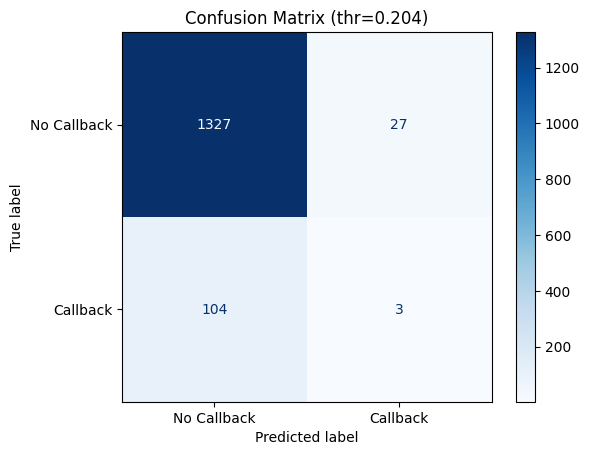

In [98]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ─── 1. Hyperparameter search space ─────────────────────────────────────────
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# ─── 2. RandomizedSearchCV setup ──────────────────────────────────────────────
base_rfc = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(
    estimator=base_rfc,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ─── 3. Fit on training data ─────────────────────────────────────────────────
rs.fit(X_train, y_train)

# ─── 4. Best model ────────────────────────────────────────────────────────────
best_rf = rs.best_estimator_
print("Best hyperparameters:", rs.best_params_)

# ─── 5. Predictions ──────────────────────────────────────────────────────────
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# # ─── 6. Overall performance ──────────────────────────────────────────────────
# auc_score = roc_auc_score(y_test, y_proba)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Test ROC AUC: {auc_score:.3f}")
# print(f"Test Accuracy: {accuracy:.3f}")

# # ─── 7. Fairness audit by race ────────────────────────────────────────────────
# results = []
# for grp in sorted(X_test['race_black'].unique()):
#     mask = X_test['race_black'] == grp
#     yt = y_test[mask]
#     yp = y_pred[mask]
#     sr = yp.mean()
#     tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
#     fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
#     tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
#     results.append((grp, sr, fpr, tpr))

# fairness_df = pd.DataFrame(results, columns=['race_black','selection_rate','fpr','tpr']) \
#                 .set_index('race_black')
# print("\nFairness metrics by race group:\n", fairness_df)



#

import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score


# 3️⃣  Choose a threshold so you see some positives
#     e.g. the score at the 95th percentile
threshold = np.percentile(y_proba, 98)
print(f"Using threshold = {threshold:.3f}")

# 4️⃣  Make hard predictions at that threshold
y_pred_thresh = (y_proba >= threshold).astype(int)

# 5. Compute metrics
accuracy = accuracy_score(y_test, y_pred_thresh)
auc_roc  = roc_auc_score(y_test, y_proba)
r2       = r2_score(y_test,    y_proba)

print(f"Threshold used: {threshold:.3f}")
print(f"Accuracy   (@ threshold): {accuracy:.3f}")
print(f"ROC AUC    (probabilities): {auc_roc:.3f}")
print(f"R² score   (probabilities vs true): {r2:.3f}")

# 5️⃣  Fairness metrics by race at this threshold
results = []
for grp in [0, 1]:
    mask = X_test['race_black'] == grp
    yt, yp = y_test[mask], y_pred_thresh[mask]
    sr = yp.mean()
    tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
    fpr = fp/(fp+tn) if tn+fp>0 else 0
    tpr = tp/(tp+fn) if tp+fn>0 else 0
    results.append((grp, sr, fpr, tpr))

fair_df = pd.DataFrame(results,
           columns=['race_black','selection_rate','fpr','tpr']
         ).set_index('race_black')
print("\nFairness metrics at this threshold:\n", fair_df)

# 6️⃣  Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['No Callback','Callback'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix (thr={threshold:.3f})')
plt.show()

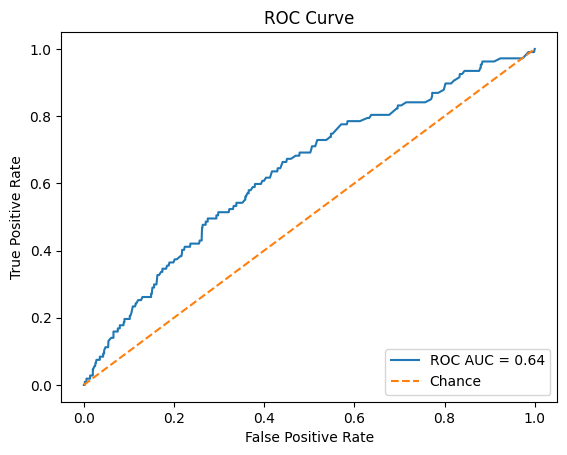

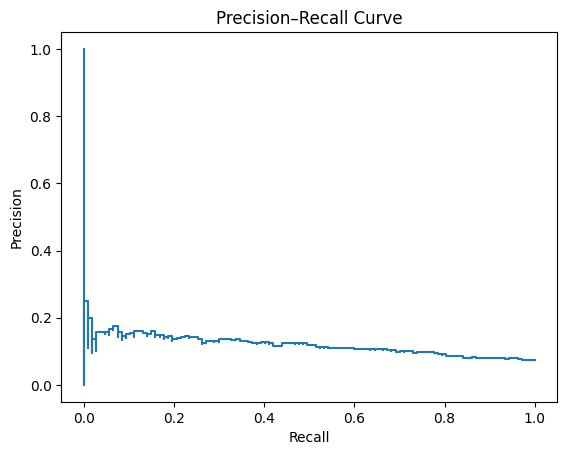

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 1. ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr_vals, tpr_vals)

plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 2. Precision–Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.step(recall_vals, precision_vals, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.show()

In [110]:
df['gender_female']

0       f
1       f
2       f
3       f
4       f
       ..
4865    f
4866    f
4867    m
4868    f
4869    f
Name: gender, Length: 4870, dtype: object

In [125]:
#new version

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# ─── 1. Define an extended feature set ───────────────────────────────────────
binary_feats = [
    'years_experience', 'college_degree', 'honors',
    'computer_skills', 'special_skills', 'volunteer',
    'military', 'employment_holes',
    'has_email_address', 'fed_contractor_missing'
]

categorical_feats = [
    'job_city', 'job_industry', 'job_type',
    'job_ownership', 'resume_quality'
]
df['gender_female'] = (df['gender'] == 'f').astype(int)
protected = ['race_black', 'gender_female']

all_feats = binary_feats + categorical_feats + protected

# ─── 2. Prepare X, y ─────────────────────────────────────────────────────────
# Assumes df is your DataFrame with these columns already cleaned
X = df[all_feats].copy()
y = df['received_callback']

# Normalize categorical strings and one-hot encode
for col in categorical_feats:
    X[col] = X[col].astype(str).str.strip().str.title()
X = pd.get_dummies(X, columns=categorical_feats, drop_first=True)

# ─── 3. Train-test split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ─── 4. Manual oversampling of the positive class ───────────────────────────
# Split into majority/minority
X_neg = X_train[y_train == 0]
y_neg = y_train[y_train == 0]
X_pos = X_train[y_train == 1]
y_pos = y_train[y_train == 1]

# Upsample positives to match negatives
X_pos_upsampled = X_pos.sample(len(X_neg), replace=True, random_state=42)
y_pos_upsampled = y_pos.loc[X_pos_upsampled.index]

# Combine back
X_train_res = pd.concat([X_neg, X_pos_upsampled])
y_train_res = pd.concat([y_neg, y_pos_upsampled])

print("Resampled distribution:", y_train_res.value_counts().to_dict())
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# ─── 2. RandomizedSearchCV setup ──────────────────────────────────────────────
base_rfc = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(
    estimator=base_rfc,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ─── 3. Fit on training data ─────────────────────────────────────────────────
rs.fit(X_train_res, y_train_res)

# ─── 4. Best model ────────────────────────────────────────────────────────────
best_rf = rs.best_estimator_
print("Best hyperparameters:", rs.best_params_)

# ─── 5. Predictions ──────────────────────────────────────────────────────────
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]



#

import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score


# 3️⃣  Choose a threshold so you see some positives
#     e.g. the score at the 95th percentile
threshold = np.percentile(y_proba, 98)
print(f"Using threshold = {threshold:.3f}")

# 4️⃣  Make hard predictions at that threshold
y_pred_thresh = (y_proba >= threshold).astype(int)

# 5. Compute metrics
accuracy = accuracy_score(y_test, y_pred_thresh)
auc_roc  = roc_auc_score(y_test, y_proba)

print(f"Threshold used: {threshold:.3f}")
print(f"Accuracy   (@ threshold): {accuracy:.3f}")
print(f"ROC AUC    (probabilities): {auc_roc:.3f}")

# 8️⃣  Fairness metrics by race
results = []
for grp in sorted(X_test['race_black'].unique()):
    mask = X_test['race_black'] == grp
    yt, yp = y_test[mask], y_pred[mask]
    sr = yp.mean()
    tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
    fpr = fp / (fp + tn) if (fp+tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp+fn) > 0 else 0
    results.append((grp, sr, fpr, tpr))

fair_df = pd.DataFrame(results, columns=['race_black','selection_rate','fpr','tpr']) \
            .set_index('race_black')
print("\nFairness metrics by race_black:\n", fair_df)

Resampled distribution: {0: 3135, 1: 3135}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/syedhumarahim/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 436, in _validate_param

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Using threshold = 0.904
Threshold used: 0.904
Accuracy   (@ threshold): 0.906
ROC AUC    (probabilities): 0.653

Fairness metrics by race_black:
             selection_rate       fpr       tpr
race_black                                    
0                 0.073969  0.069841  0.109589
1                 0.056728  0.054698  0.088889


In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix
)
import numpy as np

# 1️⃣  Feature setup (adjust if you’ve already encoded these)
binary_feats = [
    'years_experience', 'college_degree', 'honors',
    'computer_skills', 'special_skills', 'volunteer',
    'military', 'employment_holes',
    'has_email_address', 'fed_contractor_missing'
]
categorical_feats = [
    'job_city', 'job_industry', 'job_type',
    'job_ownership', 'resume_quality'
]
protected = ['race_black', 'gender_female']
all_feats = binary_feats + categorical_feats + protected

# 2️⃣  Build X, y
X = df[all_feats].copy()
y = df['received_callback']

# One-hot encode the categorical columns
for col in categorical_feats:
    X[col] = X[col].astype(str).str.strip().str.title()
X = pd.get_dummies(X, columns=categorical_feats, drop_first=True)

# 3️⃣  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# 4️⃣  Print original class balance
print("Original training distribution:\n", y_train.value_counts())

# 5️⃣  Manual oversampling of the minority class
X_neg = X_train[y_train == 0]
y_neg = y_train[y_train == 0]
X_pos = X_train[y_train == 1]
y_pos = y_train[y_train == 1]

X_pos_up = X_pos.sample(len(X_neg), replace=True, random_state=42)
y_pos_up = y_pos.loc[X_pos_up.index]

X_train_res = pd.concat([X_neg, X_pos_up])
y_train_res = pd.concat([y_neg, y_pos_up])

print("\nResampled training distribution:\n", y_train_res.value_counts())

# 6️⃣  Train AdaBoost
adb = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
adb.fit(X_train_res, y_train_res)

# 7️⃣  Evaluate on test set
y_pred = adb.predict(X_test)
y_proba = adb.predict_proba(X_test)[:, 1]



# 3️⃣  Choose a threshold so you see some positives
#     e.g. the score at the 95th percentile
threshold = np.percentile(y_proba, 88)
print(f"Using threshold = {threshold:.3f}")

# 4️⃣  Make hard predictions at that threshold
y_pred_thresh = (y_proba >= threshold).astype(int)

# 5. Compute metrics
accuracy = accuracy_score(y_test, y_pred_thresh)
auc_roc  = roc_auc_score(y_test, y_proba)

from sklearn.metrics import brier_score_loss, log_loss

brier = brier_score_loss(y_test, y_proba)
ll    = log_loss(y_test, y_proba)
print(f"Brier score : {brier:.3f}")
print(f"Log loss     : {ll:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_thresh, digits=3))



print(f"Threshold used: {threshold:.3f}")
print(f"Accuracy   (@ threshold): {accuracy:.3f}")
print(f"ROC AUC    (probabilities): {auc_roc:.3f}")

# 8️⃣  Fairness metrics by race
results = []
for grp in sorted(X_test['race_black'].unique()):
    mask = X_test['race_black'] == grp
    yt, yp = y_test[mask], y_pred[mask]
    sr = yp.mean()
    tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
    fpr = fp / (fp + tn) if (fp+tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp+fn) > 0 else 0
    results.append((grp, sr, fpr, tpr))

fair_df = pd.DataFrame(results, columns=['race_black','selection_rate','fpr','tpr']) \
            .set_index('race_black')
print("\nFairness metrics by race_black:\n", fair_df)

Original training distribution:
 received_callback
0    3135
1     274
Name: count, dtype: int64

Resampled training distribution:
 received_callback
0    3135
1    3135
Name: count, dtype: int64
Using threshold = 0.568
Brier score : 0.232
Log loss     : 0.656

Classification Report:
              precision    recall  f1-score   support

           0      0.930     0.890     0.909      1343
           1      0.159     0.237     0.190       118

    accuracy                          0.837      1461
   macro avg      0.545     0.564     0.550      1461
weighted avg      0.868     0.837     0.851      1461

Threshold used: 0.568
Accuracy   (@ threshold): 0.837
ROC AUC    (probabilities): 0.629

Fairness metrics by race_black:
             selection_rate       fpr       tpr
race_black                                    
0                 0.473684  0.460317  0.589041
1                 0.278364  0.270687  0.400000


In [132]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, roc_auc_score, confusion_matrix
)

# 1️⃣ Define or reuse y_proba, y_test, and sensitive feature
y_proba = best_rf.predict_proba(X_test)[:,1]
y_test  = y_test  # from your train_test_split
s_test  = X_test['race_black']

# 2️⃣ Set max allowable TPR gap (e.g. 5% = 0.05)
max_tpr_gap = 0.05

# 3️⃣ Search over thresholds
thresholds = np.linspace(0, 1, 101)
records = []

for thr in thresholds:
    y_pred = (y_proba >= thr).astype(int)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
  
    # Compute group TPRs
    tpr_vals = {}
    for grp in [0, 1]:
        yt = y_test[s_test == grp]
        yp = y_pred[s_test == grp]
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
        tpr_vals[grp] = tp / (tp + fn) if (tp + fn)>0 else 0

    tpr_gap = abs(tpr_vals[0] - tpr_vals[1])
    records.append({
        'threshold': thr,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'tpr_white': tpr_vals[0],
        'tpr_black': tpr_vals[1],
        'tpr_gap': tpr_gap
    })

df_thresh = pd.DataFrame(records)

# 4️⃣ Filter by TPR gap constraint
valid = df_thresh[df_thresh['tpr_gap'] <= max_tpr_gap]

# 5️⃣ Pick best threshold (max F1) among valid; fallback to overall max F1
if not valid.empty:
    best = valid.loc[valid['f1'].idxmax()]
else:
    best = df_thresh.loc[df_thresh['f1'].idxmax()]

best_thr = best['threshold']
print("Chosen threshold:", best_thr)
print(best[['precision','recall','f1','tpr_white','tpr_black','tpr_gap']])

# 6️⃣ Recompute metrics at best_thr
y_pred_best = (y_proba >= best_thr).astype(int)

print("\nOverall Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("ROC AUC :", roc_auc_score(y_test, y_proba))

# Fairness at best_thr
rows = []
for grp in [0,1]:
    mask = s_test == grp
    yt, yp = y_test[mask], y_pred_best[mask]
    sr = yp.mean()
    tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
    fpr = fp/(fp+tn) if (fp+tn)>0 else 0
    tpr = tp/(tp+fn) if (tp+fn)>0 else 0
    rows.append((grp, sr, fpr, tpr))

fair_df_best = pd.DataFrame(rows, columns=['race_black','selection_rate','fpr','tpr']).set_index('race_black')
print("\nFairness metrics at chosen threshold:\n", fair_df_best)

Chosen threshold: 0.11
precision    0.131528
recall       0.576271
f1           0.214173
tpr_white    0.561644
tpr_black    0.600000
tpr_gap      0.038356
Name: 11, dtype: float64

Overall Metrics:
Accuracy: 0.6584531143052703
ROC AUC : 0.6528357964082436

Fairness metrics at chosen threshold:
             selection_rate       fpr       tpr
race_black                                    
0                 0.389758  0.369841  0.561644
1                 0.320580  0.302945  0.600000


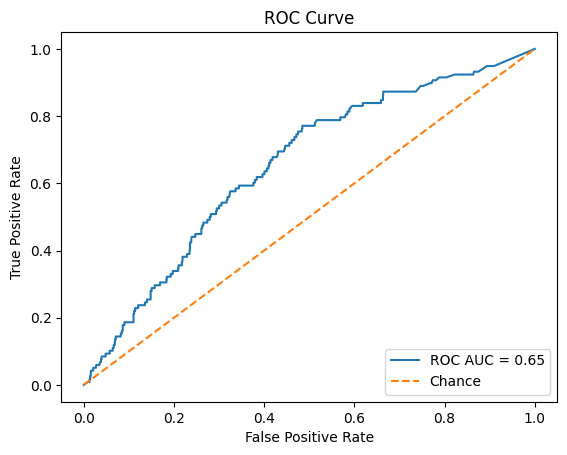

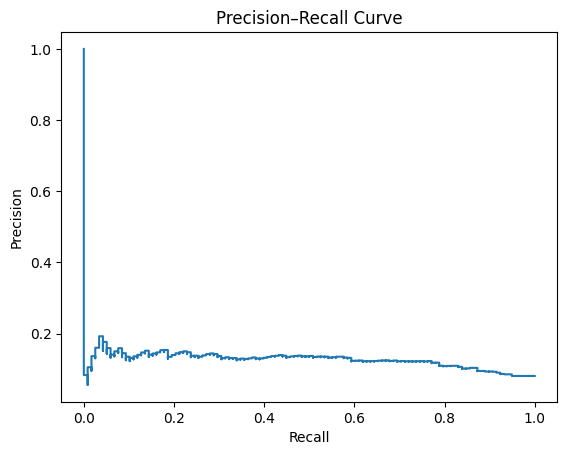

In [136]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 1. ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr_vals, tpr_vals)

plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 2. Precision–Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.step(recall_vals, precision_vals, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.show()

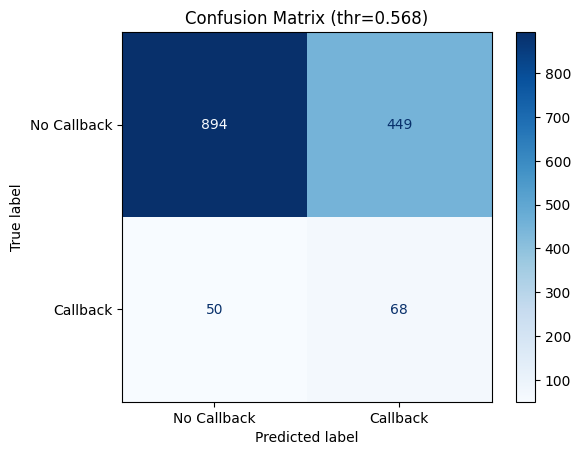

In [135]:

# 6️⃣  Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['No Callback','Callback'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix (thr={threshold:.3f})')
plt.show()

In [137]:
import pickle

# Save the final trained AdaBoost model (assuming it's called 'adb')
with open('final_adaboost_model.pkl', 'wb') as f:
    pickle.dump(adb, f)

print("Final AdaBoost model saved as 'final_adaboost_model.pkl'")

Final AdaBoost model saved as 'final_adaboost_model.pkl'
